# DeepLearning - Prevedi l'andamento del BitCoin

In [1]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from Historic_Crypto import HistoricalData

# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(42)

In [2]:
# candles = HistoricalData(
#     ticker='BTC-USD',
#     granularity=3600,
#     start_date='2017-1-1-00-00',
#     end_date='2021-12-14-00-00'
# ).retrieve_data()
#
# candles.to_csv('BTCUSD_data.csv')

In [3]:
candles = pd.read_csv('BTCUSD_data.csv')
candles.head(10)

,time,low,high,open,close,volume
0,2017-01-01 01:00:00,968.21,972.00,970.99,970.49,148.353801
1,2017-01-01 02:00:00,967.00,971.99,970.49,967.95,108.436139
2,2017-01-01 03:00:00,967.57,969.47,967.83,968.14,125.094314
3,2017-01-01 04:00:00,966.64,968.62,968.17,968.10,79.411830
4,2017-01-01 05:00:00,964.37,968.10,968.10,966.92,159.864321
5,2017-01-01 06:00:00,964.54,969.63,966.92,969.45,68.547126
6,2017-01-01 07:00:00,968.54,970.56,969.45,969.47,82.882209
7,2017-01-01 08:00:00,968.11,969.58,969.04,969.15,89.593688
8,2017-01-01 09:00:00,968.60,970.68,969.16,970.38,52.618346
9,2017-01-01 10:00:00,969.79,974.99,970.36,974.99,100.240926


In [4]:
candles['time'] = pd.to_datetime(candles['time'])
candles.set_index('time', inplace=True)

candles.head()

,low,high,open,close,volume
time,,,,,
2017-01-01 01:00:00,968.21,972.00,970.99,970.49,148.353801
2017-01-01 02:00:00,967.00,971.99,970.49,967.95,108.436139
2017-01-01 03:00:00,967.57,969.47,967.83,968.14,125.094314
2017-01-01 04:00:00,966.64,968.62,968.17,968.10,79.411830
2017-01-01 05:00:00,964.37,968.10,968.10,966.92,159.864321


# Le "Candele Giapponesi"

---

# Data Exploration

Limiti temporali del dataset scaricato

In [5]:
print('Date disponibili:', candles.iloc[0].name, '-', candles.iloc[-1].name)
print(len(candles.index), 'candele H1')

Date disponibili: 2017-01-01 01:00:00 - 2021-12-14 00:00:00
43352 candele H1


Statistiche sui dati

In [6]:
candles.describe()

,low,high,open,close,volume
count,43352.000000,43352.000000,43352.000000,43352.000000,43352.000000
mean,15044.328844,15229.901597,15141.061195,15142.165940,638.666188
std,16635.525476,16845.817889,16744.581786,16745.104479,784.881177
min,0.060000,769.150000,0.060000,757.950000,0.286254
25%,5358.765000,5442.082500,5398.860000,5399.607500,232.312466
50%,8482.000000,8577.125000,8534.795000,8534.930000,412.268907
75%,13092.872500,13295.247500,13186.125000,13190.915000,750.146840
max,68456.500000,69000.000000,68638.470000,68639.630000,19591.576090


## Grafici

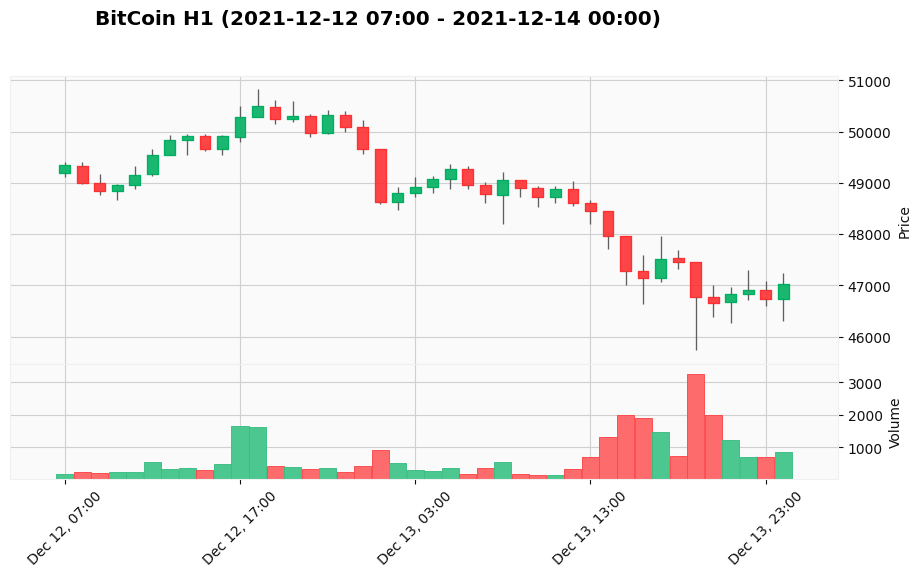

In [7]:
title = 'BitCoin H1 (' + str(candles.iloc[-42].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-42:], 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

# Analisi Tecnica

## Medie Mobili

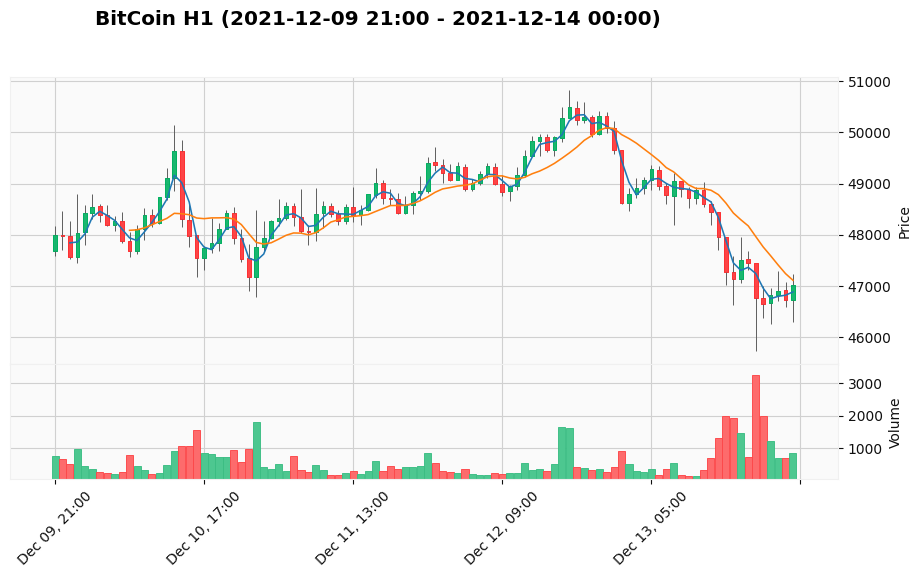

In [8]:
title = 'BitCoin H1 (' + str(candles.iloc[-100].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-100:], 
    mav=(3, 11), 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

## Le bande di Bollinger

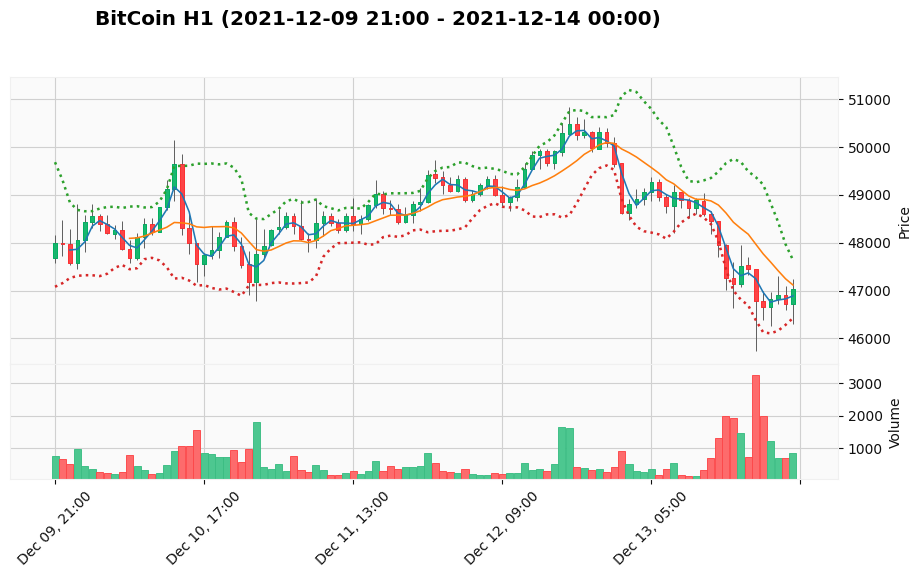

In [9]:
mean = candles['close']
mean = mean.rolling(window=10).mean()
std_dev = candles['close']
std_dev = std_dev.rolling(window=10).std()
candles['UpperBB'] = mean + (2 * std_dev)
candles['LowerBB'] = mean - (2 * std_dev)
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-100:], linestyle='dotted')
mpf.plot(
    candles.iloc[-100:], 
    type='candle',
    mav=(3, 11),
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    addplot=bollinger_bands_plot, 
    title=title
)

## Prezzo su volume

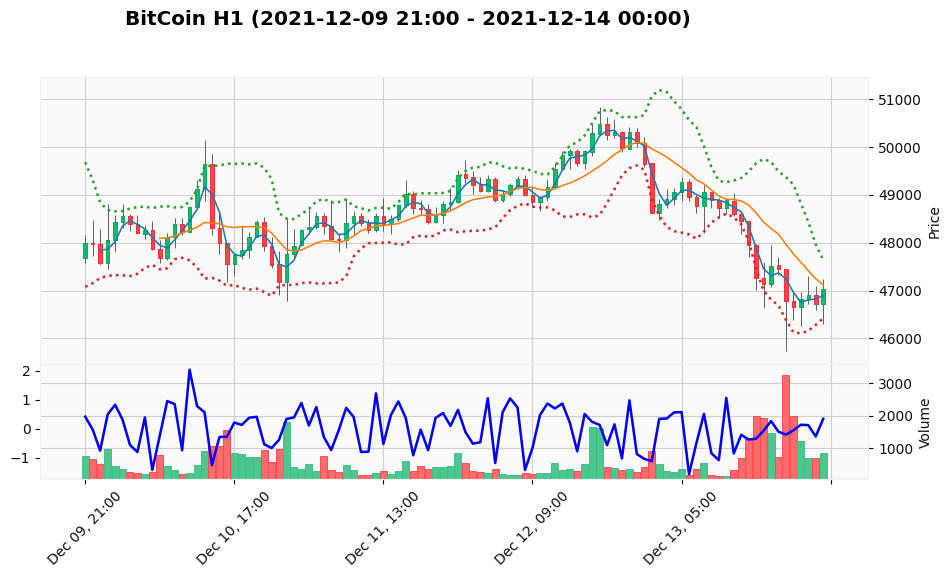

In [10]:
price_over_volume = (candles['close'] - candles['open']) / candles['volume']

candles['price_over_vol'] = price_over_volume

price_over_volume_plot = mpf.make_addplot(price_over_volume[-100:], panel=1, color='blue')
mpf.plot(
    candles.iloc[-100:],
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[bollinger_bands_plot, price_over_volume_plot],
    title=title
)

## Accelerazione volumetrica

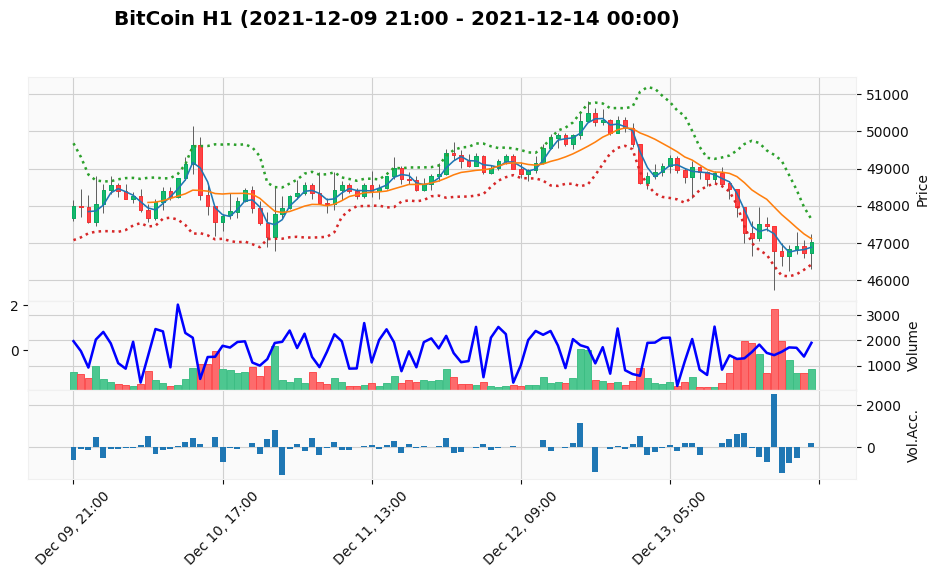

In [11]:
volume_diff = candles['volume'] - candles['volume'].shift(1)
volume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')
candles['vol_diff'] = volume_diff

mpf.plot(
    candles.iloc[-100:],  
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[
        bollinger_bands_plot, 
        price_over_volume_plot, 
        volume_diff_plot
    ], 
    title=title
)

# Creazione dataset temporale

## Normalizzazione dei dati

In [12]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)

print(candles.iloc[0])
print('  ------')
print(candles_norm[0])

low               968.210000
high              972.000000
open              970.990000
close             970.490000
volume            148.353801
UpperBB                  NaN
LowerBB                  NaN
price_over_vol     -0.003370
vol_diff                 NaN
Name: 2017-01-01 01:00:00, dtype: float64
  ------
[0.20848554 0.2017838  0.20848735 0.20187862 0.2045347         nan
        nan 0.49121588        nan]


## Rimozione valori NaN
derivati dal calcolo delle bande di Bollinger

In [13]:
candles_norm = candles_norm[10:]

## Costruzione dataset basato su serie temporali

In [14]:
x_candles = []
x_time = []
y = []

step_back = 48

for i in range(len(candles_norm) - step_back):
    example_candles = []
    example_time = []
    
    for o in range(0, step_back):
        example_candles.append(candles_norm[i + o])
        t = candles.iloc[10 + i + o].name
        example_time.append([t.hour / 24, t.weekday() / 7])
    
    x_candles.append(example_candles)
    x_time.append(example_time)
    y.append(candles_norm[i+step_back][3])

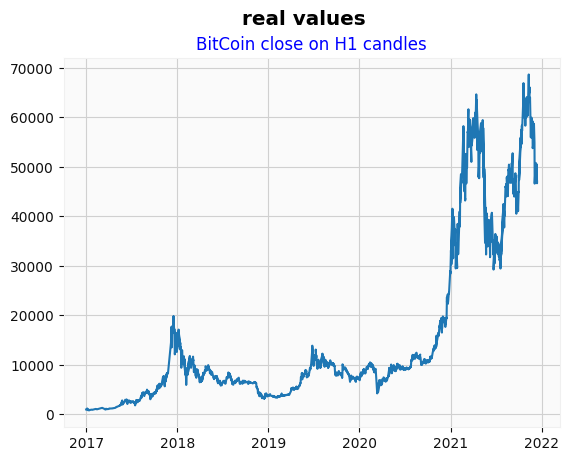

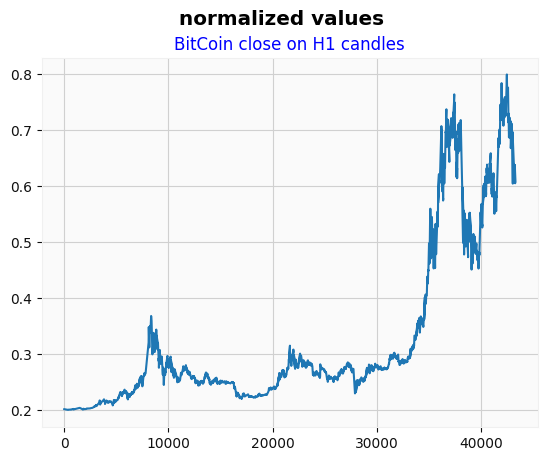

In [15]:
plt.plot(candles['close'])
plt.title('BitCoin close on H1 candles', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('real values')
plt.show()

plt.plot(y)
plt.title('BitCoin close on H1 candles', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('normalized values')
plt.show()

### Creazione dataset per addestramento e validazione del modello predittivo

In [16]:
split_point = int(len(x_candles) * 0.9)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [17]:
print(x_train_candles.shape)
print(x_train_time.shape)
print(y_train.shape)
print('dal', candles.iloc[0].name, 'al', candles.iloc[split_point + step_back].name)

print('   --------')

print(x_test_candles.shape)
print(x_test_time.shape)
print(y_test.shape)
print('dal', candles.iloc[split_point + step_back + 1].name, 'al', candles.iloc[-step_back].name)

(38964, 48, 9)
(38964, 48, 2)
(38964,)
dal 2017-01-01 01:00:00 al 2021-06-16 05:00:00
   --------
(4330, 48, 9)
(4330, 48, 2)
(4330,)
dal 2021-06-16 06:00:00 al 2021-12-12 01:00:00


## Implementazione modello predittivo

---

#### Funzione di attivazione "Swish"

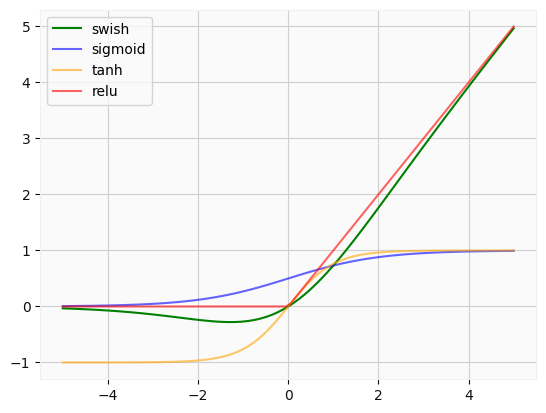

In [18]:
def swish(x):
    return keras.backend.sigmoid(x) * x

x = np.linspace(-5, 5, 100)
plt.plot(x, keras.backend.eval(swish(x)), label='swish', color='green')
plt.plot(x, keras.backend.eval(keras.backend.sigmoid(x)), label='sigmoid', color='blue', alpha=0.6)
plt.plot(x, keras.backend.eval(keras.backend.tanh(x)), label='tanh', color='orange', alpha=0.6)
plt.plot(x, keras.backend.eval(keras.backend.relu(x)), label='relu', color='red', alpha=0.6)
plt.legend(loc="upper left")
plt.show()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Candles (InputLayer)            [(None, 48, 9)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 48, 32)       896         Candles[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 32)       2048        Candles[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 48, 32)       3776        Candles[0][0]                    
______________________________________________________________________________________________

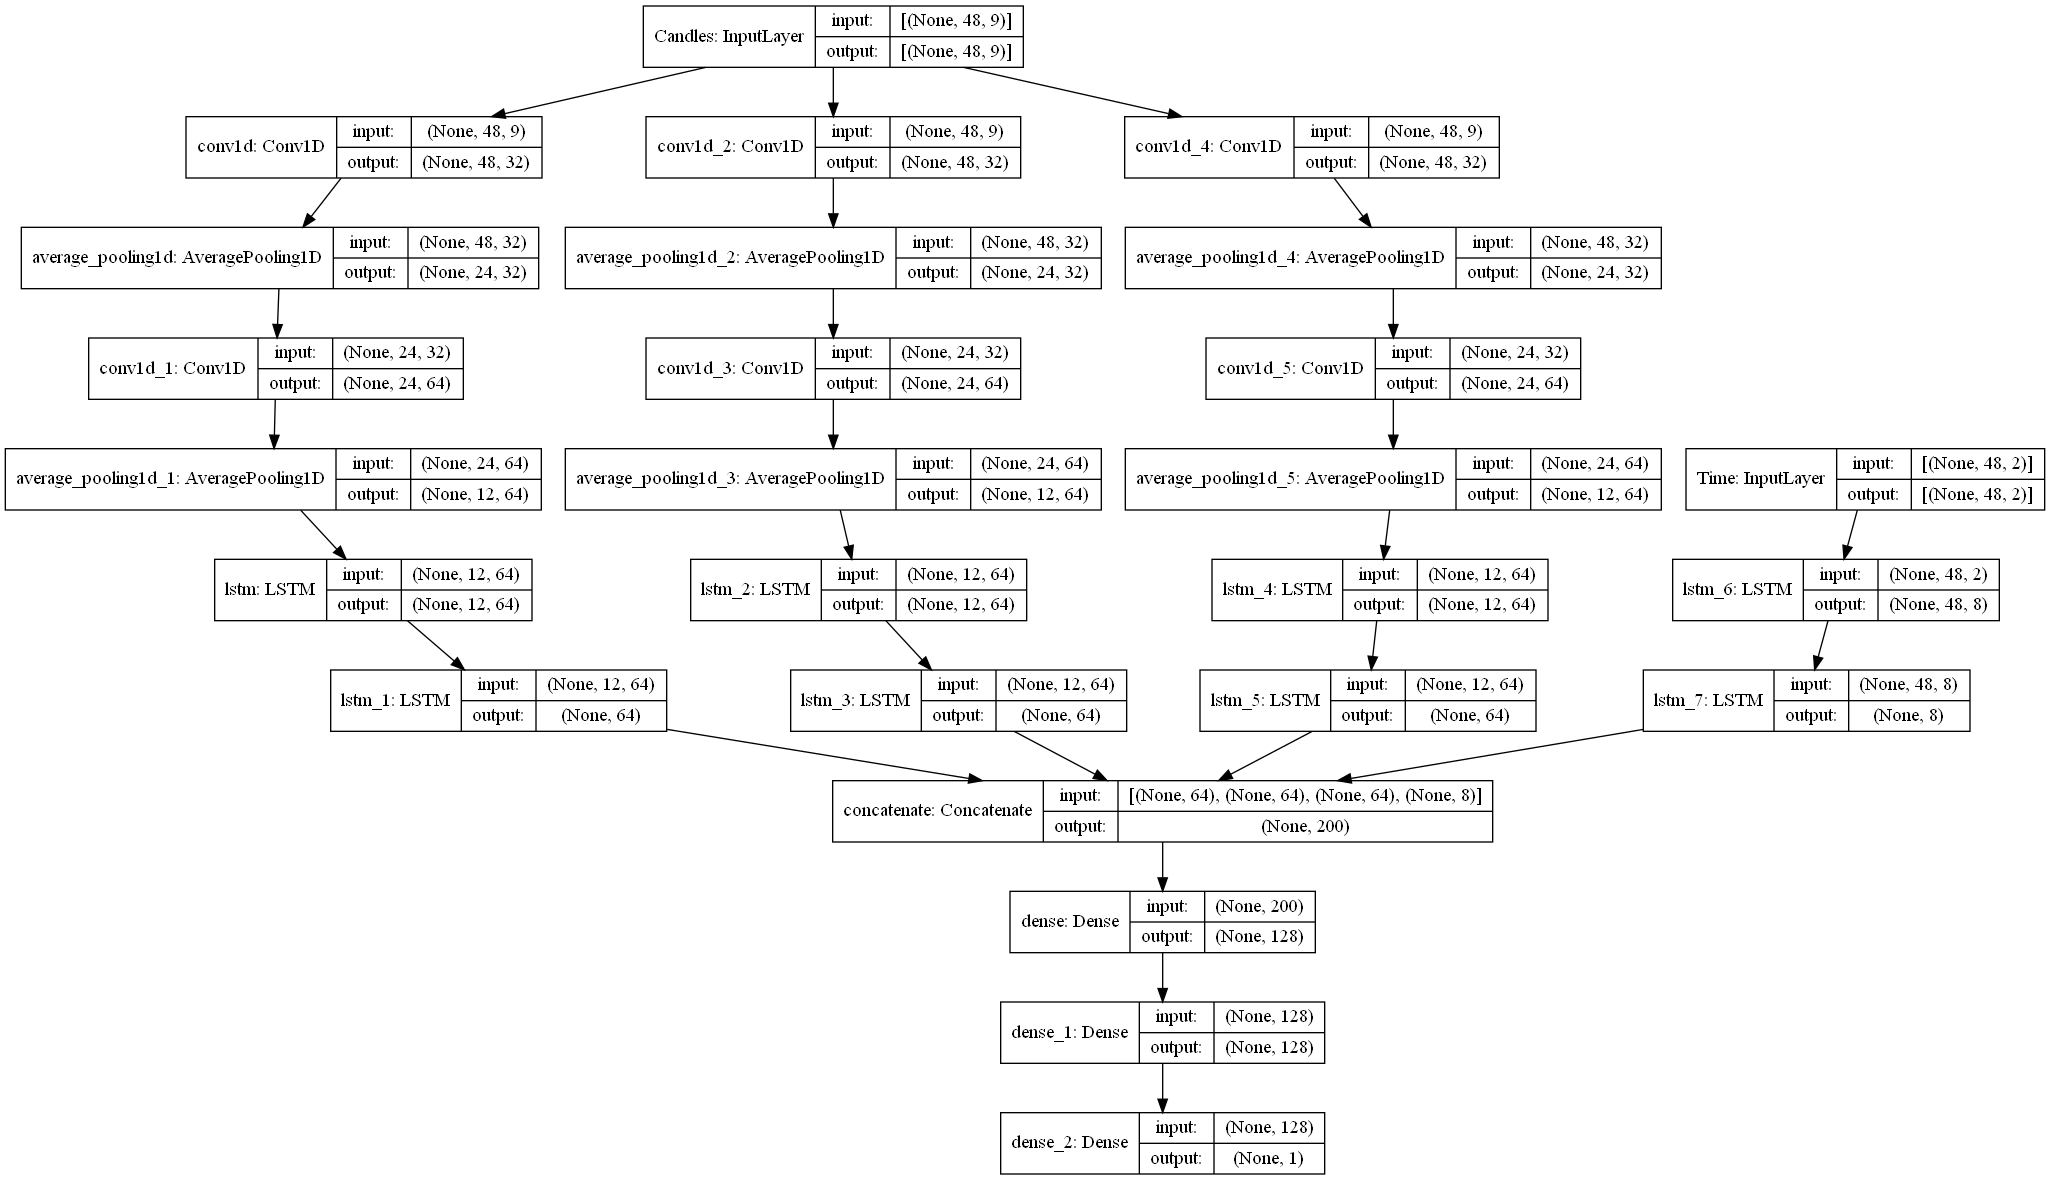

In [19]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=64, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=64)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1], x_train_candles.shape[2]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1], x_train_time.shape[2]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=3)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=7, kernel_size_2=7)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=13, kernel_size_2=13)

lstm_time_1 = keras.layers.LSTM(units=8, return_sequences=True)(input_time)
lstm_time_2 = keras.layers.LSTM(units=8)(lstm_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, lstm_time_2])

dense_1 = keras.layers.Dense(units=128, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=128, activation=keras.activations.swish)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()
keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=20,
    batch_size=4096,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    ),
    callbacks=model_checkpoint_callback
)

model.load_weights('weights/weights')

Epoch 1/20
10/10 [==============================] - 11s 308ms/step - loss: 0.1858 - val_loss: 0.3432
Epoch 2/20
10/10 [==============================] - 1s 73ms/step - loss: 0.0669 - val_loss: 0.2626

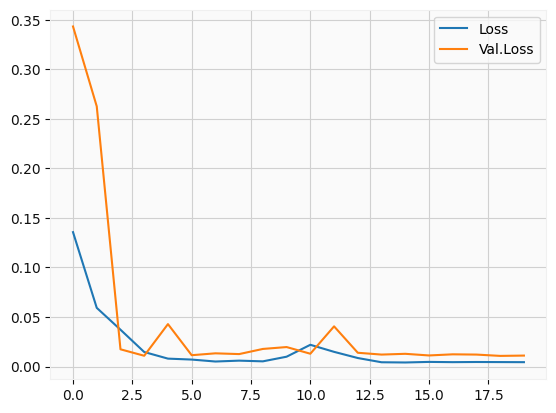

In [21]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Utilizzo e validazione del modello predittivo

In [22]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

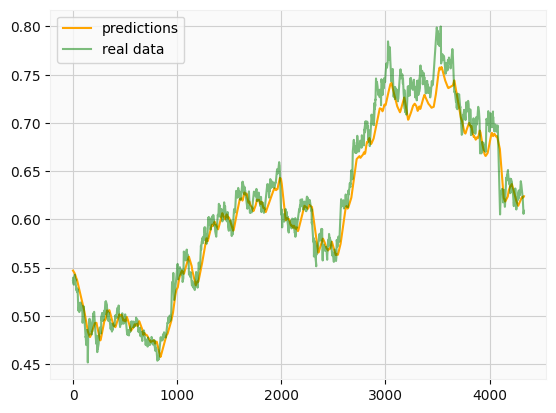

In [23]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(y_test, color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [24]:
def denorm(value):
    example = [0.5 for x in range(9)]
    example[3] = value
    return scaler.inverse_transform([example])[0][3]

In [25]:
def backtesting(fee=0.025):
    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(x_candles)):
        prediction = preds[i - split_point][0]
        predicted_close = denorm(prediction)
        previous_close = denorm(candles_norm[i][3])
        real_next_close = denorm(candles_norm[i+1][3])

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', (len(x_candles) - split_point) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      504 ( 327 ok 177 ko )
No-op    3826
Wallet   57062.500249999975
Drawback -2639.5287500000013


Total earned 57062.500249999975


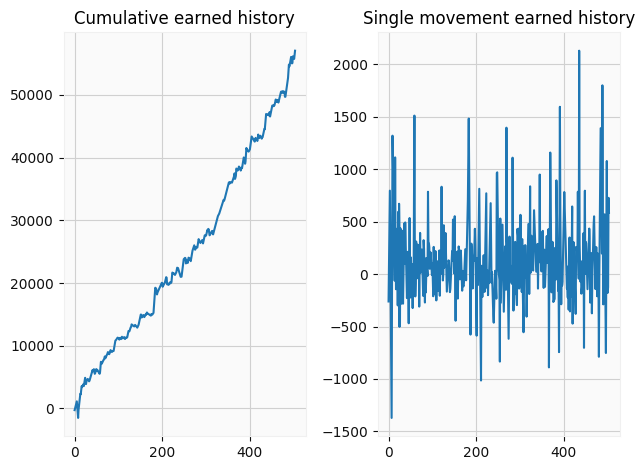

In [26]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## addestramento su più epoche

In [27]:
preds_old = preds
y_test_old = y_test

In [28]:
print('addestramento su 2000 epoche... attendere...')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time], 
    y_train, 
    epochs=2000,
    initial_epoch=21, 
    batch_size=4096,
    validation_data=([x_test_candles, x_test_time], y_test),
    callbacks=model_checkpoint_callback,
    verbose=0
)

addestramento su 2000 epoche... attendere...


In [29]:
model.load_weights('weights/weights')

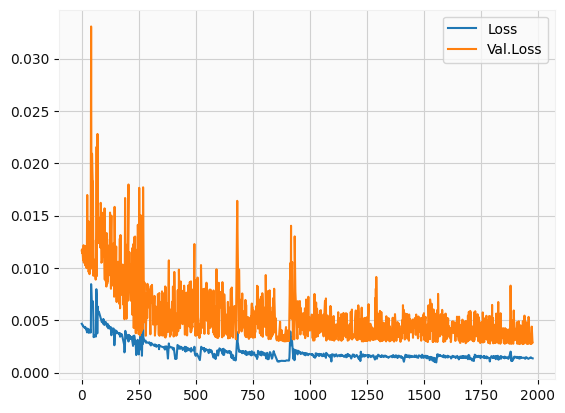

In [30]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [31]:
preds = model.predict([x_test_candles, x_test_time], batch_size=512)

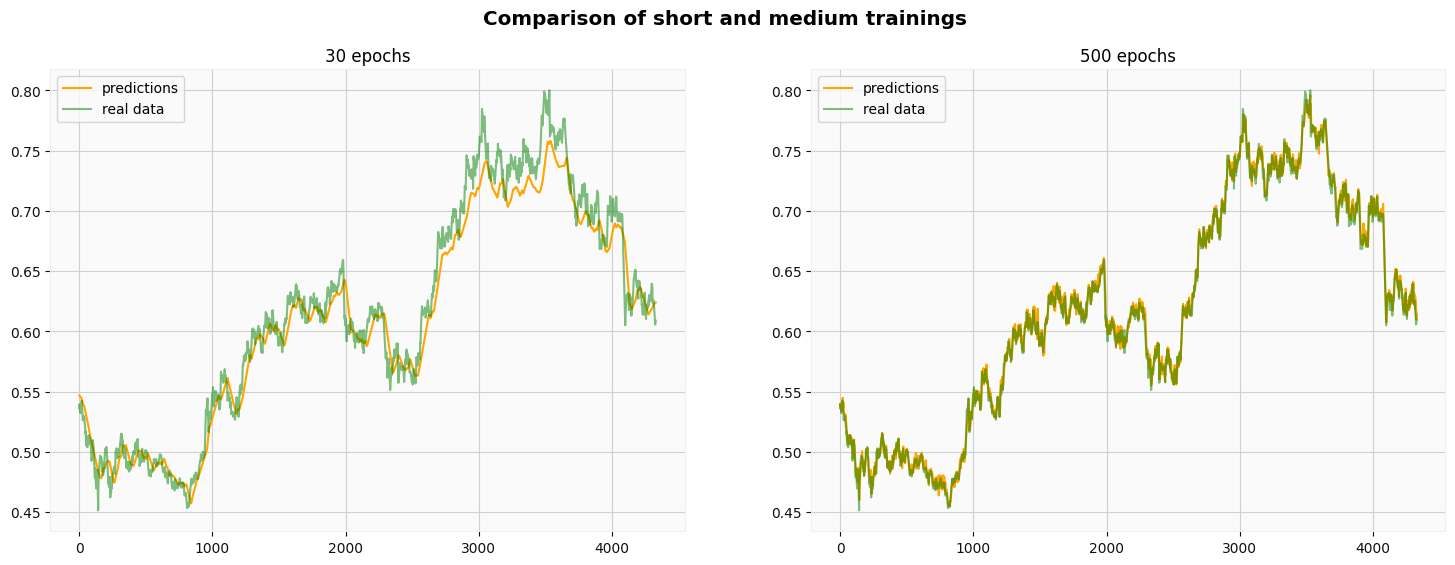

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('30 epochs')
ax1.plot(preds_old, color='orange', label='predictions')
ax1.plot(y_test_old, color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('500 epochs')
ax2.plot(preds, color='orange', label='predictions')
ax2.plot(y_test, color='green', alpha=0.5, label='real data')
ax2.legend()

plt.show()

In [33]:
total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      1485 ( 832 ok 653 ko )
No-op    2845
Wallet   82080.603
Drawback -2639.5287500000013


Total earned 82080.603


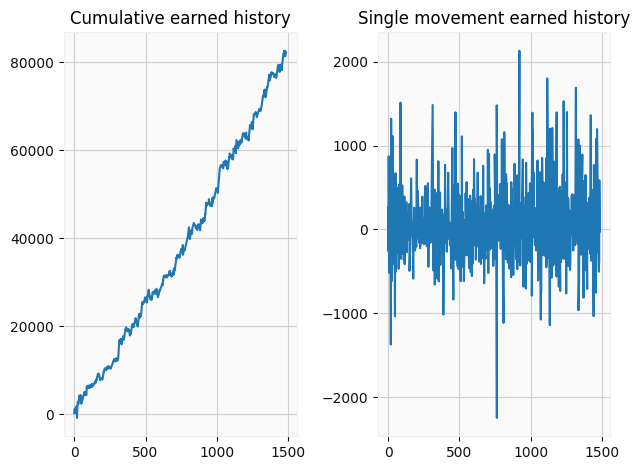

In [34]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()